In [ ]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(98765)


In [ ]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util

In [3]:
# Define augmentation
def do_augment_data(data, labels):
    image = data
    mask = labels

    seq = iaa.Sequential([
            iaa.Fliplr(0.0),
            iaa.Crop(percent=(0, 0.05)),
            iaa.Affine(
                scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
                rotate=(-4, 4),
                shear=(-2, 2)
            )
    ], random_order = True)

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_image(image)
    mask_aug = seq_det.augment_image(mask)

    # augmentation makes some of these values not discreet, fix them here.
    mask_aug[mask_aug > 0.5] = 1
    mask_aug[mask_aug <= 0.5] = 0
            
    return image_aug, mask_aug


In [4]:
# Create a generator that uses the Image data provider
from tf_unet.image_util import ImageDataProvider
from PIL import Image

class GrayImageDataProvider(ImageDataProvider):
    def __init__(self, search_path, a_min=None, a_max=None, data_suffix=".png", mask_suffix='_mask.png', shuffle_data=True, augment_data=False):
        self.augment_data = augment_data
        super(GrayImageDataProvider, self).__init__(search_path, a_min, a_max, data_suffix, mask_suffix, shuffle_data)

    def _load_file(self, path, dtype=np.float32):
        return np.array(Image.open(path).convert('L'), dtype)
    
    def _post_process(self, data, labels):
        if (self.augment_data):
            data_aug, labels_aug = do_augment_data(data, labels)
        else:
            data_aug, labels_aug = data, labels

        # visualize (comment out)
#         fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
#         ax[0].imshow(data, aspect="auto")
#         ax[1].imshow(data_aug, aspect="auto")        
        
        return data_aug, labels_aug;



In [5]:
generator = GrayImageDataProvider("data/training/*.png", data_suffix=".png", mask_suffix="_mask.png", augment_data=True)

Number of files used: 32
Number of channels: 1
Number of classes: 2


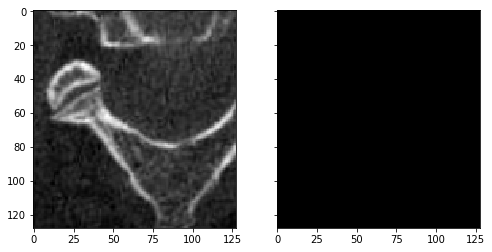

In [6]:
# visualize one of the files

x_test, y_test = generator(1)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")




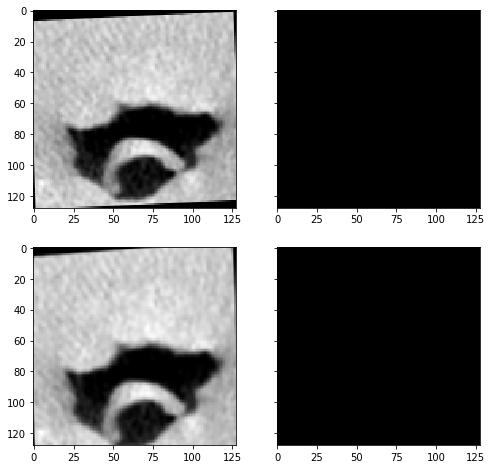

In [7]:
# visualize the augmentation

x_test, y_test = generator(1)

image = x_test[0,...,0]
mask = y_test[0,...,1]

image_aug, mask_aug = do_augment_data(image, mask)

fig, ax = plt.subplots(2,2, sharey=True, figsize=(8,8))
ax[0, 0].imshow(image, aspect="auto")
ax[1, 0].imshow(image_aug, aspect="auto")
ax[0, 1].imshow(mask, aspect="auto")
ax[1, 1].imshow(mask_aug, aspect="auto")


In [51]:
# The network
net = unet.Unet(channels=generator.channels, n_class=generator.n_class, layers=3, features_root=64)
#net = unet.Unet(channels=generator.channels, n_class=generator.n_class, cost="cross_entropy", cost_kwargs={"class_weights": [0.7, 0.3]}, layers=3, features_root=16)
#net = unet.Unet(channels=generator.channels, n_class=generator.n_class, cost="dice_coefficient", layers=3, features_root=16)



2019-05-11 19:13:11,596 Layers 3, features 64, filter size 3x3, pool size: 2x2


In [52]:
# Train the model
#trainer = unet.Trainer(net, optimizer="momentum", batch_size=1, opt_kwargs=dict(momentum=0.2))
trainer = unet.Trainer(net, optimizer="adam")
path = trainer.train(generator, "./unet_trained", training_iters=32, epochs=100, display_step=16)

2019-05-11 19:13:14,260 Removing '/Users/nsemsarilar/code/dl/tf_unet/cbct/prediction'
2019-05-11 19:13:14,291 Removing '/Users/nsemsarilar/code/dl/tf_unet/cbct/unet_trained'
2019-05-11 19:13:14,294 Allocating '/Users/nsemsarilar/code/dl/tf_unet/cbct/prediction'
2019-05-11 19:13:14,295 Allocating '/Users/nsemsarilar/code/dl/tf_unet/cbct/unet_trained'
2019-05-11 19:13:15,863 Verification error= 0.9%, loss= 0.6637
2019-05-11 19:13:16,142 Start optimization
2019-05-11 19:13:17,331 Iter 0, Minibatch Loss= 0.5398, Training Accuracy= 0.9764, Minibatch error= 2.4%
2019-05-11 19:13:26,514 Iter 16, Minibatch Loss= 0.0646, Training Accuracy= 0.9888, Minibatch error= 1.1%
2019-05-11 19:13:34,908 Epoch 0, Average loss: 0.1320, learning rate: 0.0010
2019-05-11 19:13:35,810 Verification error= 0.9%, loss= 0.0508
2019-05-11 19:13:36,795 Iter 32, Minibatch Loss= 0.0131, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:13:45,813 Iter 48, Minibatch Loss= 0.0026, Training Accuracy= 1.0000, M

2019-05-11 19:20:21,475 Iter 704, Minibatch Loss= 0.0458, Training Accuracy= 0.9908, Minibatch error= 0.9%
2019-05-11 19:20:30,212 Iter 720, Minibatch Loss= 0.0894, Training Accuracy= 0.9751, Minibatch error= 2.5%
2019-05-11 19:20:38,315 Epoch 22, Average loss: 0.0358, learning rate: 0.0010
2019-05-11 19:20:39,260 Verification error= 0.9%, loss= 0.0311
2019-05-11 19:20:40,706 Iter 736, Minibatch Loss= 0.0811, Training Accuracy= 0.9775, Minibatch error= 2.2%
2019-05-11 19:20:49,799 Iter 752, Minibatch Loss= 0.0382, Training Accuracy= 0.9872, Minibatch error= 1.3%
2019-05-11 19:20:57,609 Epoch 23, Average loss: 0.0338, learning rate: 0.0010
2019-05-11 19:20:58,434 Verification error= 0.9%, loss= 0.0258
2019-05-11 19:20:59,641 Iter 768, Minibatch Loss= 0.0432, Training Accuracy= 0.9897, Minibatch error= 1.0%
2019-05-11 19:21:08,557 Iter 784, Minibatch Loss= 0.0235, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:21:16,436 Epoch 24, Average loss: 0.0291, learning rate: 0.001

2019-05-11 19:28:05,191 Iter 1456, Minibatch Loss= 0.0105, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:28:14,662 Epoch 45, Average loss: 0.0309, learning rate: 0.0010
2019-05-11 19:28:15,866 Verification error= 0.8%, loss= 0.0224
2019-05-11 19:28:17,869 Iter 1472, Minibatch Loss= 0.0187, Training Accuracy= 0.9929, Minibatch error= 0.7%
2019-05-11 19:28:28,801 Iter 1488, Minibatch Loss= 0.0458, Training Accuracy= 0.9858, Minibatch error= 1.4%
2019-05-11 19:28:37,225 Epoch 46, Average loss: 0.0239, learning rate: 0.0010
2019-05-11 19:28:38,123 Verification error= 0.9%, loss= 0.0550
2019-05-11 19:28:39,739 Iter 1504, Minibatch Loss= 0.0616, Training Accuracy= 0.9845, Minibatch error= 1.5%
2019-05-11 19:28:49,870 Iter 1520, Minibatch Loss= 0.0430, Training Accuracy= 0.9879, Minibatch error= 1.2%
2019-05-11 19:28:59,310 Epoch 47, Average loss: 0.0304, learning rate: 0.0010
2019-05-11 19:29:00,415 Verification error= 0.5%, loss= 0.0143
2019-05-11 19:29:01,942 Iter 1536, Mi

2019-05-11 19:35:25,379 Iter 2192, Minibatch Loss= 0.0025, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:35:33,296 Epoch 68, Average loss: 0.0156, learning rate: 0.0010
2019-05-11 19:35:34,212 Verification error= 0.3%, loss= 0.0101
2019-05-11 19:35:35,876 Iter 2208, Minibatch Loss= 0.0018, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:35:44,304 Iter 2224, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:35:52,288 Epoch 69, Average loss: 0.0112, learning rate: 0.0010
2019-05-11 19:35:53,195 Verification error= 0.5%, loss= 0.0107
2019-05-11 19:35:54,936 Iter 2240, Minibatch Loss= 0.0156, Training Accuracy= 0.9935, Minibatch error= 0.6%
2019-05-11 19:36:03,401 Iter 2256, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:36:11,239 Epoch 70, Average loss: 0.0142, learning rate: 0.0010
2019-05-11 19:36:12,148 Verification error= 0.3%, loss= 0.0089
2019-05-11 19:36:13,862 Iter 2272, Mi

2019-05-11 19:42:42,834 Iter 2928, Minibatch Loss= 0.0081, Training Accuracy= 0.9966, Minibatch error= 0.3%
2019-05-11 19:42:50,592 Epoch 91, Average loss: 0.0108, learning rate: 0.0010
2019-05-11 19:42:51,481 Verification error= 0.3%, loss= 0.0078
2019-05-11 19:42:53,357 Iter 2944, Minibatch Loss= 0.0114, Training Accuracy= 0.9960, Minibatch error= 0.4%
2019-05-11 19:43:01,751 Iter 2960, Minibatch Loss= 0.0248, Training Accuracy= 0.9892, Minibatch error= 1.1%
2019-05-11 19:43:09,619 Epoch 92, Average loss: 0.0097, learning rate: 0.0010
2019-05-11 19:43:10,503 Verification error= 0.3%, loss= 0.0082
2019-05-11 19:43:12,385 Iter 2976, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:43:20,643 Iter 2992, Minibatch Loss= 0.0000, Training Accuracy= 1.0000, Minibatch error= 0.0%
2019-05-11 19:43:28,440 Epoch 93, Average loss: 0.0110, learning rate: 0.0010
2019-05-11 19:43:29,329 Verification error= 0.4%, loss= 0.0089
2019-05-11 19:43:31,226 Iter 3008, Mi

Number of files used: 9
Number of channels: 1
Number of classes: 2
INFO:tensorflow:Restoring parameters from ./unet_trained/model.ckpt


2019-05-11 21:43:10,348 Restoring parameters from ./unet_trained/model.ckpt
2019-05-11 21:43:11,052 Model restored from file: ./unet_trained/model.ckpt


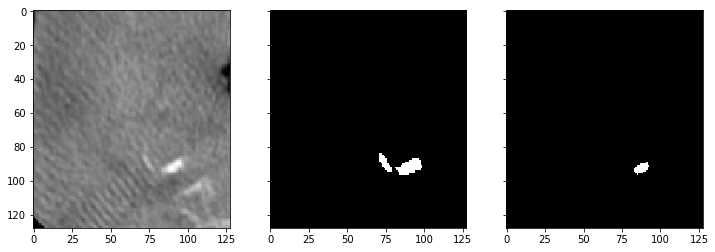

In [109]:
# Test the model

testGenerator = GrayImageDataProvider("data/test/*.png", data_suffix=".png", mask_suffix="_mask.png", augment_data=False)
x_test, y_test = testGenerator(1)
prediction = net.predict("./unet_trained/model.ckpt", x_test)
mask = prediction[0,...,1] > 0.5
mask = np.pad(mask, (20,20), 'constant', constant_values=(0, 0))

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(mask, aspect="auto")

                                                                                                                                                                                                                                          